In [12]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt

# Import libraries
import tensorflow as tf
import keras
import keras.backend as K
from keras.models import Model
# Optimizer and regularization
from keras.regularizers import l2
from keras.losses import mean_squared_error, mean_absolute_error
# Keras layers
from keras.layers.convolutional import Conv1D
from keras.layers import Dense, Dropout, Flatten, Input, BatchNormalization, Activation
from keras.layers.pooling import MaxPooling1D, AveragePooling1D, MaxPooling2D, AveragePooling2D

# Model architecture
from resnet_1d_angles import *

In [3]:
outputs = np.genfromtxt("../Data/Processed/angles/outputs.txt")
outputs[np.isnan(outputs)] = 0.0
outputs.shape

(98222, 2)

In [4]:
out = []
out.append(np.sin(outputs[:,0]))
out.append(np.cos(outputs[:,0]))
out.append(np.sin(outputs[:,1]))
out.append(np.cos(outputs[:,1]))
out = np.array(out).T
print(out.shape)


(98222, 4)


In [7]:
def get_ins(path = "../Data/Processed/angles/input_aa.txt", pssm=None):
    """ Gets inputs from both AminoAcids (input_aa) and PSSM (input_pssm)"""
    # handles both files
    if pssm: path = "../Data/Processed/angles/input_pssm.txt"
    # Opn file and read text
    with open(path, "r") as f:
        lines = f.read().split('\n')
    # Extract numeric data from text
    pre_ins = []
    for i,line in enumerate(lines):
        # Read each protein separately
        if line == "NEW":
            prot = []
            raw = lines[i+1:i+(17*2+1)]
            # Read each line as a vector + ensemble one-hot vectors as a matrix
            for r in raw:
                prot.append(np.array([float(x) for x in r.split(" ") if x != ""]))
            # Add prot to dataset
            pre_ins.append(np.array(prot))  
    
    return np.array(pre_ins)

In [8]:
aas = get_ins()
pssms = get_ins(pssm=True)
# Check that shapes match
print(aas.shape, pssms.shape)
# Concatenate input features
inputs = np.concatenate((aas[:, :, :20], pssms[:, :, :20], aas[:, :, 20:]), axis=2) 
inputs.shape

(98222, 34, 22) (98222, 34, 21)


(98222, 34, 42)

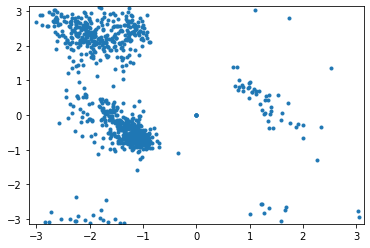

In [9]:
plt.scatter(outputs[:1000,0], outputs[:1000,1], marker=".")
plt.xlim(-np.pi, np.pi)
plt.ylim(-np.pi, np.pi)
plt.show()

In [13]:
# Using AMSGrad optimizer for speed 
kernel_size, filters = 3, 16
adam = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=True)
# Create model
model = resnet_v2(input_shape=(17*2,42), depth=20, num_classes=4, conv_first=True)
model.compile(optimizer=adam, loss=custom_mse_mae,
              metrics=["mean_absolute_error", "mean_squared_error"])
model.summary()

/Users/hrishikeshmahajan/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
2022-03-10 15:59:33.966462: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-10 15:59:33.966608: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 34, 42)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 34, 16)       2032        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 34, 16)      64          ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 34, 16)       0          

 conv1d_12 (Conv1D)             (None, 17, 64)       8256        ['add_2[0][0]']                  
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 17, 64)      256         ['conv1d_12[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 activation_9 (Activation)      (None, 17, 64)       0           ['batch_normalization_9[0][0]']  
                                                                                                  
 conv1d_13 (Conv1D)             (None, 17, 64)       12352       ['activation_9[0][0]']           
                                                                                                  
 batch_normalization_10 (BatchN  (None, 17, 64)      256         ['conv1d_13[0][0]']              
 ormalizat

                                                                                                  
 dense (Dense)                  (None, 4)            3076        ['flatten[0][0]']                
                                                                                                  
Total params: 328,308
Trainable params: 324,340
Non-trainable params: 3,968
__________________________________________________________________________________________________


In [14]:
# Separate data between training and testing
split = 38700
x_train, x_test = inputs[:split], inputs[split:]
y_train, y_test = out[:split], out[split:]

In [16]:
his = model.fit(x_train, y_train, epochs=5, batch_size=16, verbose=1, validation_data=(x_test, y_test))

Epoch 1/5


InvalidArgumentError: Cannot assign a device for operation model/conv1d/Conv1D/ExpandDims_1/ReadVariableOp: Could not satisfy explicit device specification '' because the node {{colocation_node model/conv1d/Conv1D/ExpandDims_1/ReadVariableOp}} was colocated with a group of nodes that required incompatible device '/job:localhost/replica:0/task:0/device:GPU:0'. All available devices [/job:localhost/replica:0/task:0/device:CPU:0, /job:localhost/replica:0/task:0/device:GPU:0]. 
Colocation Debug Info:
Colocation group had the following types and supported devices: 
Root Member(assigned_device_name_index_=2 requested_device_name_='/job:localhost/replica:0/task:0/device:GPU:0' assigned_device_name_='/job:localhost/replica:0/task:0/device:GPU:0' resource_device_name_='/job:localhost/replica:0/task:0/device:GPU:0' supported_device_types_=[CPU] possible_devices_=[]
ResourceApplyAdamWithAmsgrad: CPU 
ReadVariableOp: GPU CPU 
_Arg: GPU CPU 

Colocation members, user-requested devices, and framework assigned devices, if any:
  model_conv1d_conv1d_expanddims_1_readvariableop_resource (_Arg)  framework assigned device=/job:localhost/replica:0/task:0/device:GPU:0
  adam_adam_update_resourceapplyadamwithamsgrad_m (_Arg)  framework assigned device=/job:localhost/replica:0/task:0/device:GPU:0
  adam_adam_update_resourceapplyadamwithamsgrad_v (_Arg)  framework assigned device=/job:localhost/replica:0/task:0/device:GPU:0
  adam_adam_update_resourceapplyadamwithamsgrad_vhat (_Arg)  framework assigned device=/job:localhost/replica:0/task:0/device:GPU:0
  model/conv1d/Conv1D/ExpandDims_1/ReadVariableOp (ReadVariableOp) 
  conv1d/kernel/Regularizer/Square/ReadVariableOp (ReadVariableOp) 
  Adam/Adam/update/ResourceApplyAdamWithAmsgrad (ResourceApplyAdamWithAmsgrad) /job:localhost/replica:0/task:0/device:GPU:0

	 [[{{node model/conv1d/Conv1D/ExpandDims_1/ReadVariableOp}}]] [Op:__inference_train_function_9956]